# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---



## Camera calibration using chessboard images

Import require libraries

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
import pickle
%matplotlib inline

Load chessboard images

In [2]:
# Importing test images
chess_filenames_dir = "camera_cal/"
chess_imgs = np.array([(np.array(plt.imread(chess_filenames_dir + img)), img) for img in os.listdir(chess_filenames_dir)])

Display all the chessboard images

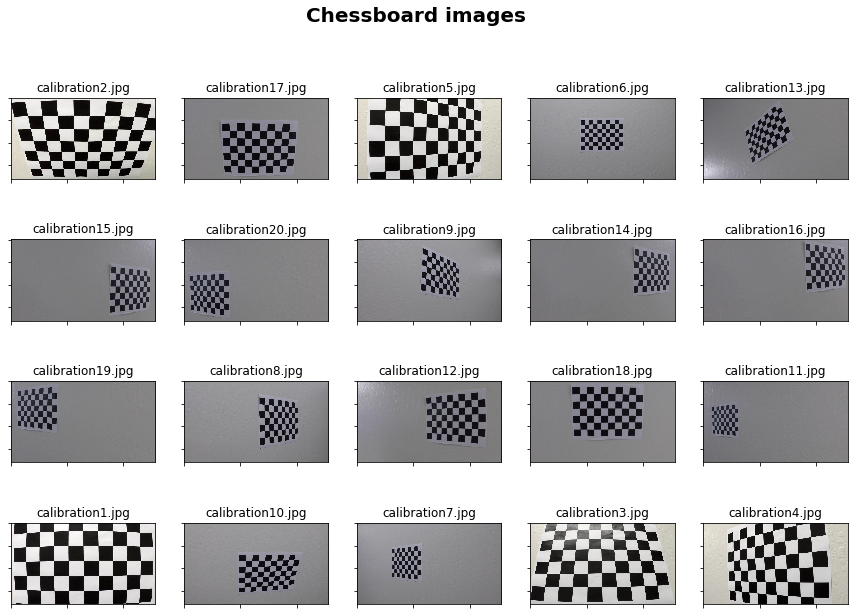

In [3]:
fig, ax = plt.subplots(4, 5, figsize=(15, 10))
plt.suptitle('Chessboard images', fontsize=20, fontweight='bold')
for i, img in enumerate(chess_imgs):
    ax = ax.ravel()
    ax[i].imshow(img[0])
    ax[i].set_title(img[1])
    
# hide both x and y ticks
plt.setp([a.get_xticklabels() for a in ax.ravel()], visible=False)
plt.setp([a.get_yticklabels() for a in ax.ravel()], visible=False)
plt.draw()    

### Extract the camera calibration points

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
Chessboard x : 9, y : 6

In [4]:
chess_corners_x = 9
chess_corners_y = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((chess_corners_x * chess_corners_y, 3), np.float32)
objp[:,:2] = np.mgrid[0:chess_corners_x,0:chess_corners_y].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

chess_calib_imgs = []

# Step through the list and search for chessboard corners
for img in chess_imgs:
    gray = cv2.cvtColor(img[0], cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (chess_corners_x, chess_corners_y),None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        proc_img = cv2.drawChessboardCorners(img[0], (chess_corners_x, chess_corners_y), corners, ret)
        chess_calib_imgs.append((proc_img, img[1]))

print("Done findChessboardCorners.")

Done findChessboardCorners.


Draw chessboard corner images

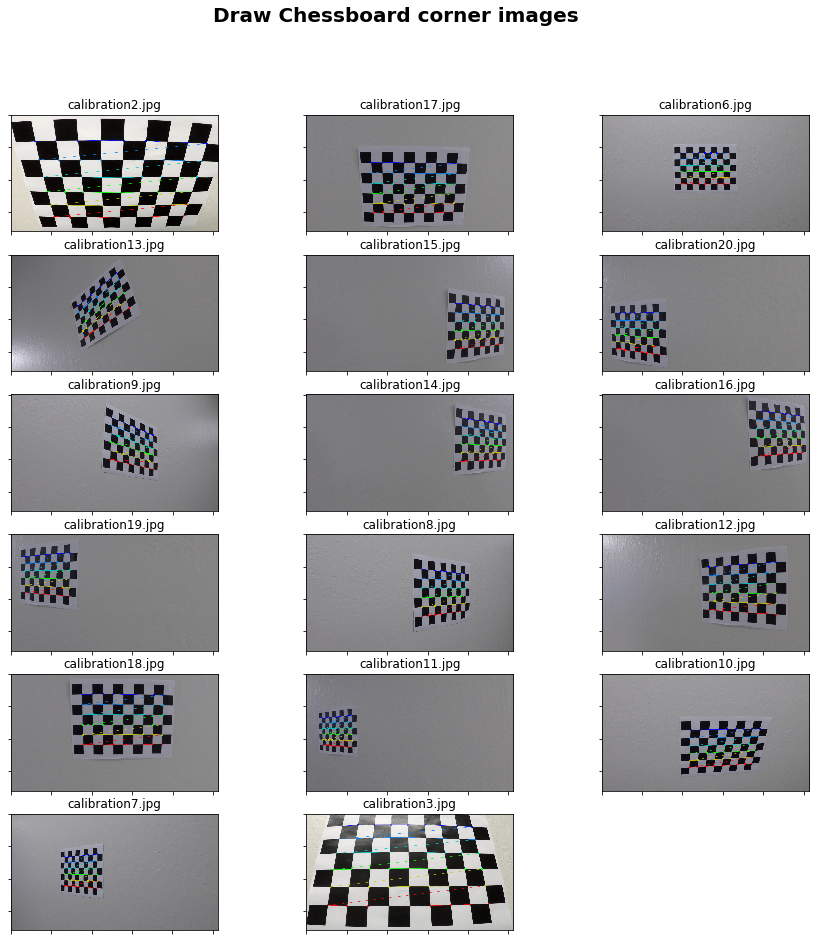

In [5]:
fig, ax = plt.subplots(6, 3, figsize=(15, 15))
plt.suptitle('Draw Chessboard corner images', fontsize=20, fontweight='bold')
for i, img in enumerate(chess_calib_imgs):
    ax = ax.ravel()
    ax[i].imshow(img[0])
    ax[i].set_title(img[1])

ax[17].axis('off')
    
# hide both x and y ticks
plt.setp([a.get_xticklabels() for a in ax.ravel()], visible=False)
plt.setp([a.get_yticklabels() for a in ax.ravel()], visible=False)
plt.draw()

### Save and load calibration points

Save chessboard corner calibration points

In [6]:
chess_pickle = "chessboard_corner_points.pickle"
if not os.path.isfile(chess_pickle):
    print('Saving data to pickle file...')
    try:
        with open(chess_pickle, 'wb') as pfile:
            pickle.dump(
                {
                    'objpoints': objpoints,
                    'imgpoints': imgpoints,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', chess_pickle, ':', e)
        raise

print('Data cached in pickle file...')

Data cached in pickle file...


Load chessboard corner calibration points

In [7]:
chess_pickle = "chessboard_corner_points.pickle"

if os.path.isfile(chess_pickle):
    dist_pickle = pickle.load( open( chess_pickle, "rb" ) )
    objpoints = dist_pickle["objpoints"]
    imgpoints = dist_pickle["imgpoints"]
    print("Load data sucessfully...")
else:
    print("Load data failed...")

Load data sucessfully...


Function that performs image distortion correction

In [8]:
def correct_undistort(img, objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

## Apply a distortion correction to raw images
Load test images

In [9]:
# Importing test images
test_filenames_dir = "test_images/"
test_images = np.array([(np.array(plt.imread(test_filenames_dir + img)), img) for img in os.listdir(test_filenames_dir)])

Test on a distorted image and display the undistorted image

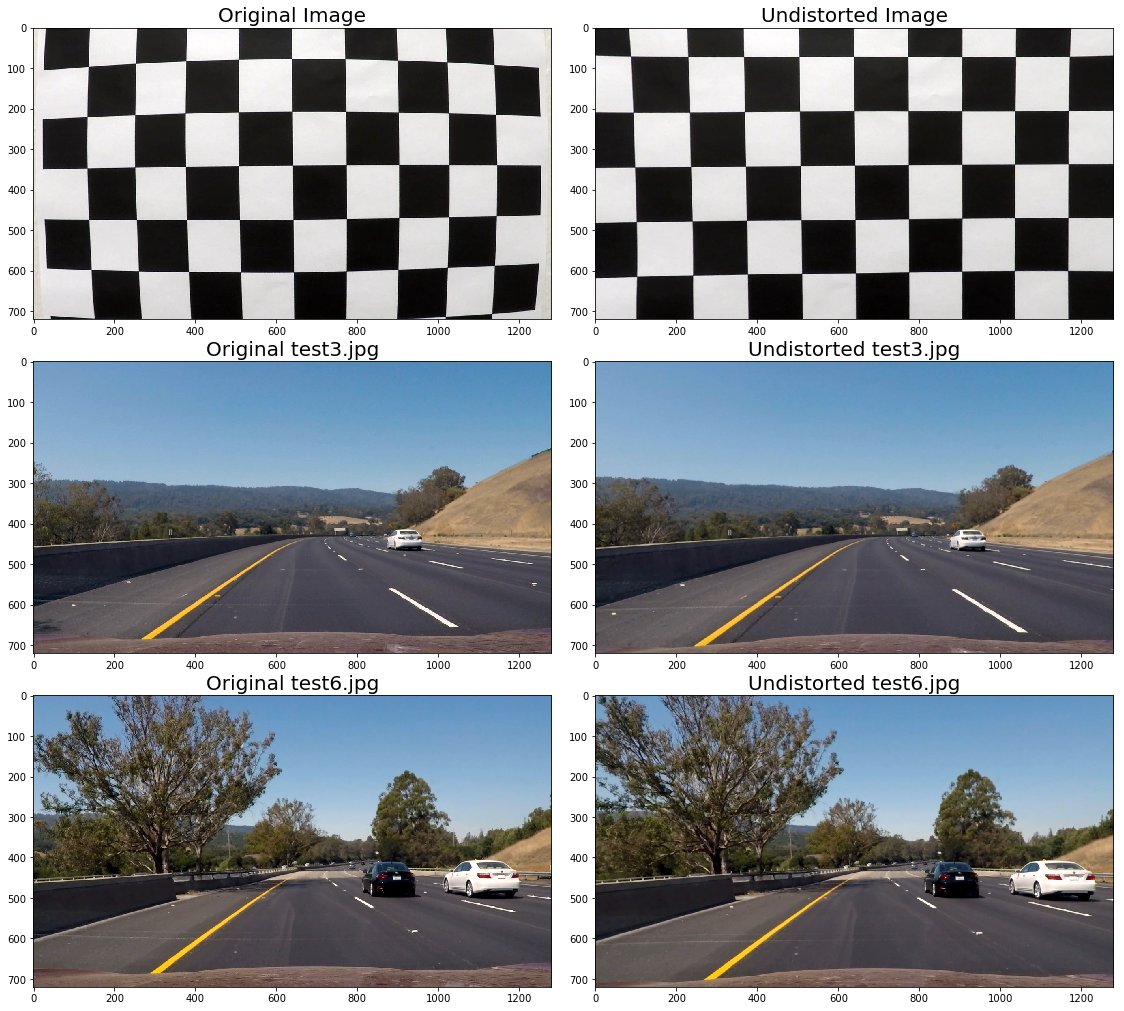

In [10]:
test_distorted_img_name = "camera_cal/calibration1.jpg"
test_distorted_img = plt.imread(test_distorted_img_name)

test_undistorted_img = correct_undistort(test_distorted_img, objpoints, imgpoints)

f, ax = plt.subplots(3, 2, figsize=(15, 15))
f.tight_layout()
ax = ax.ravel()
ax[0].imshow(test_distorted_img)
ax[0].set_title('Original Image', fontsize=20)
ax[1].imshow(test_undistorted_img)
ax[1].set_title('Undistorted Image', fontsize=20)

ax[2].imshow(test_images[0][0])
ax[2].set_title('Original ' + test_images[0][1], fontsize=20)
test_img1_undistorted = correct_undistort(test_images[0][0], objpoints, imgpoints)
ax[3].imshow(test_img1_undistorted)
ax[3].set_title('Undistorted ' + test_images[0][1], fontsize=20)

ax[4].imshow(test_images[1][0])
ax[4].set_title('Original ' + test_images[1][1], fontsize=20)
test_img2_undistorted = correct_undistort(test_images[1][0], objpoints, imgpoints)
ax[5].imshow(test_img2_undistorted)
ax[5].set_title('Undistorted ' + test_images[1][1], fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Image Thresholding

### Functions for image processing
Image processing functions such as s-channel colour filtering and sobel thresholding

In [11]:
def abs_sobel_thresh(img, sobel_kernel=3, orient='x', thresh=(20, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate directional gradient
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Apply threshold
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return grad_binary

def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate gradient magnitude
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    # Apply threshold
    mag_binary[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate gradient direction
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    # Apply threshold
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return dir_binary

def hls_thresh(img, channel_name='h', thresh=(200, 255)):
    # Convert to HLS color space and separate the selected channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    if channel_name == 'h':
        channel = hls[:,:,0]
    elif channel_name == 'l':
        channel = hls[:,:,1]
    else:
        channel = hls[:,:,2]
    
    # Creating image masked in a channel
    binary = np.zeros_like(channel)
    binary[(channel >= thresh[0]) & (channel <= thresh[1])] = 1
    return binary

def hsv_thresh(img, channel_name='h', thresh=(200, 255)):
    # Convert to HLS color space and separate the selected channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    if channel_name == 'h':
        channel = hls[:,:,0]
    elif channel_name == 's':
        channel = hls[:,:,1]
    else:
        channel = hls[:,:,2]
    
    # Creating image masked in a channel
    binary = np.zeros_like(channel)
    binary[(channel >= thresh[0]) & (channel <= thresh[1])] = 1
    return binary

def pers_transform(img, src, dst):
    # Grab the image shape
    h, w = img.shape[:2]
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, (w, h), flags=cv2.INTER_LINEAR)
    # Return the resulting image and matrix
    Minv = cv2.getPerspectiveTransform(dst, src)

    return warped, M, Minv

def lab_thresh(img, channel_name='l', thresh=(190, 255)):
    # Normalises and thresholds to the B channel
    # Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    
    if channel_name == 'l':
        channel = lab[:,:,0]
    elif channel_name == 'a':
        channel = lab[:,:,1]
    else:
        channel = lab[:,:,2]
    # Don't normalize if there are no yellows in the image
    if np.max(channel) > 175:
        channel = channel*(255/np.max(channel))
    #  Apply a threshold
    binary_output = np.zeros_like(channel)
    binary_output[((channel > thresh[0]) & (channel <= thresh[1]))] = 1
    return binary_output

### Visualize perspective transform

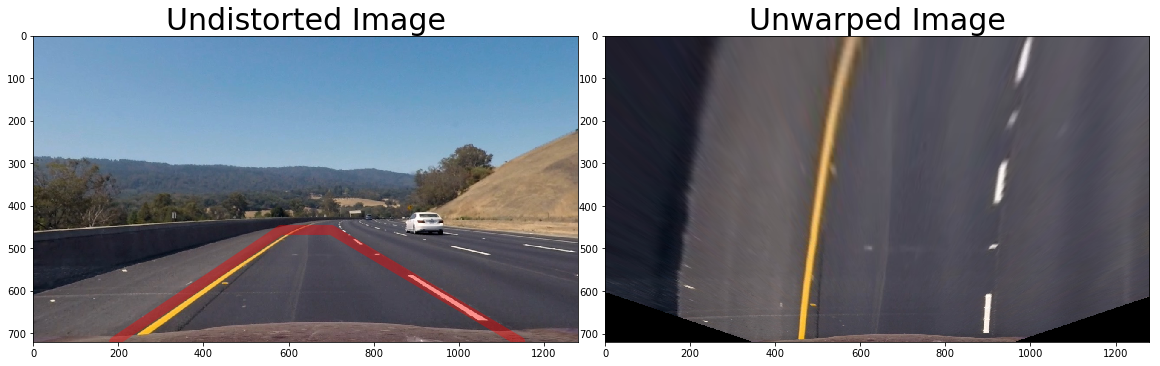

In [12]:
# Lane masking and coordinates for perspective transform
h, w = test_img1_undistorted.shape[:2]

src = np.float32([[190, 720],
                  [582, 457],
                  [701, 457],
                  [1145, 720]])
offset = [250,0]
dst = np.float32([src[0] + offset,
                  np.array([src[0, 0], 0]) + offset, 
                  np.array([src[3, 0], 0]) - offset,
                  src[3] - offset])

test_img1_unwarped, M, Minv = pers_transform(test_img1_undistorted, src, dst)

# Visualize warp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(test_img1_undistorted)
x = [src[0][0],src[1][0],src[2][0],src[3][0]]
y = [src[0][1],src[1][1],src[2][1],src[3][1]]
ax1.plot(x, y, color='#ff0000', alpha=0.4, linewidth=10, solid_capstyle='round', zorder=2)
ax1.set_ylim([h, 0])
ax1.set_xlim([0, w])

ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(test_img1_unwarped)
ax2.set_title('Unwarped Image', fontsize=30)
plt.show()

### Explore and Visualize multiple colorspace channels

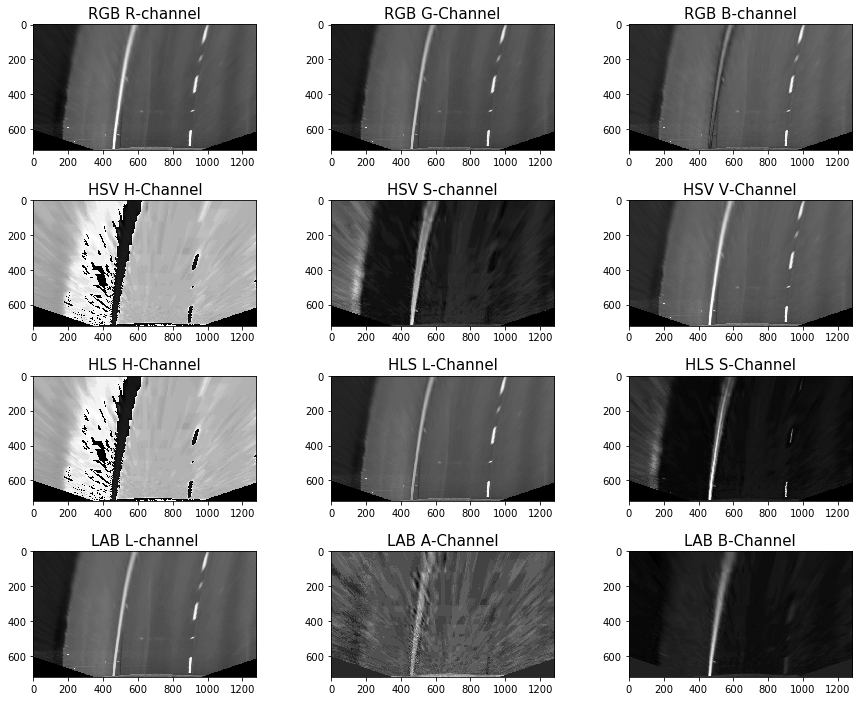

In [13]:
# Visualize multiple color space channels
test_img1_unwarped_R = test_img1_unwarped[:,:,0]
test_img1_unwarped_G = test_img1_unwarped[:,:,1]
test_img1_unwarped_B = test_img1_unwarped[:,:,2]

test_img1_unwarped_HSV = cv2.cvtColor(test_img1_unwarped, cv2.COLOR_RGB2HSV)
test_img1_unwarped_H = test_img1_unwarped_HSV[:,:,0]
test_img1_unwarped_S = test_img1_unwarped_HSV[:,:,1]
test_img1_unwarped_V = test_img1_unwarped_HSV[:,:,2]

test_img1_unwarped_HLS = cv2.cvtColor(test_img1_unwarped, cv2.COLOR_RGB2HLS)
test_img1_unwarped_H_ = test_img1_unwarped_HLS[:,:,0]
test_img1_unwarped_L_ = test_img1_unwarped_HLS[:,:,1]
test_img1_unwarped_S_ = test_img1_unwarped_HLS[:,:,2]

test_img1_unwarped_LAB = cv2.cvtColor(test_img1_unwarped, cv2.COLOR_RGB2Lab)
test_img1_unwarped_L = test_img1_unwarped_LAB[:,:,0]
test_img1_unwarped_A = test_img1_unwarped_LAB[:,:,1]
test_img1_unwarped_B2 = test_img1_unwarped_LAB[:,:,2]

# Display plot
fig, axs = plt.subplots(4, 3, figsize=(16, 12))
fig.subplots_adjust(hspace = .4, wspace=.001)
axs = axs.ravel()
fs = 15

axs[0].imshow(test_img1_unwarped_R, cmap='gray')
axs[0].set_title('RGB R-channel', fontsize=fs)
axs[1].imshow(test_img1_unwarped_G, cmap='gray')
axs[1].set_title('RGB G-Channel', fontsize=fs)
axs[2].imshow(test_img1_unwarped_B, cmap='gray')
axs[2].set_title('RGB B-channel', fontsize=fs)
axs[3].imshow(test_img1_unwarped_H, cmap='gray')
axs[3].set_title('HSV H-Channel', fontsize=fs)
axs[4].imshow(test_img1_unwarped_S, cmap='gray')
axs[4].set_title('HSV S-channel', fontsize=fs)
axs[5].imshow(test_img1_unwarped_V, cmap='gray')
axs[5].set_title('HSV V-Channel', fontsize=fs)
axs[6].imshow(test_img1_unwarped_H_, cmap='gray')
axs[6].set_title('HLS H-Channel', fontsize=fs)
axs[7].imshow(test_img1_unwarped_L_, cmap='gray')
axs[7].set_title('HLS L-Channel', fontsize=fs)
axs[8].imshow(test_img1_unwarped_S_, cmap='gray')
axs[8].set_title('HLS S-Channel', fontsize=fs)
axs[9].imshow(test_img1_unwarped_L, cmap='gray')
axs[9].set_title('LAB L-channel', fontsize=fs)
axs[10].imshow(test_img1_unwarped_A, cmap='gray')
axs[10].set_title('LAB A-Channel', fontsize=fs)
axs[11].imshow(test_img1_unwarped_B2, cmap='gray')
axs[11].set_title('LAB B-Channel', fontsize=fs)
plt.show()

### Color Space Binary Thresholding
Using HLS colorspace

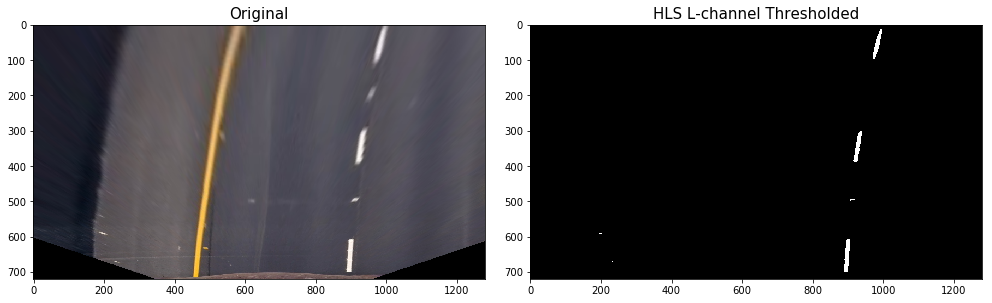

In [14]:
# HLS L-channel
bin_l = hls_thresh(test_img1_unwarped, channel_name='l', thresh=(200, 255))
fig, ax = plt.subplots(1, 2, figsize=(17,24))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
ax[0].set_title('Original', fontsize=15)
ax[1].set_title('HLS L-channel Thresholded', fontsize=15)

ax[0].imshow(test_img1_unwarped, cmap='gray')
ax[1].imshow(bin_l, cmap='gray')
plt.show()

Using LAB B-channel

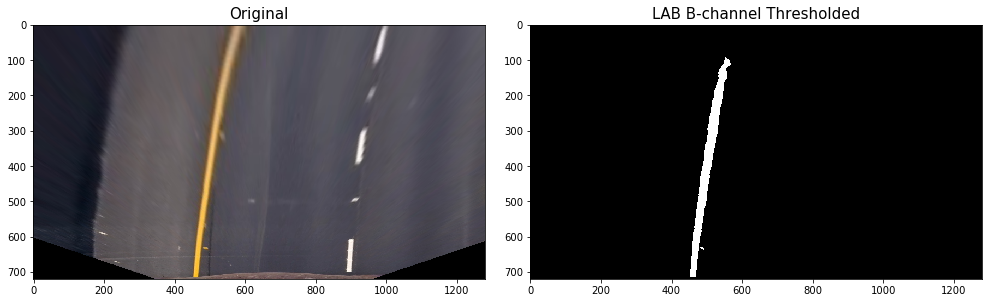

In [15]:
# LAB B-channel
bin_b = lab_thresh(test_img1_unwarped, channel_name='b', thresh=(190, 255))
fig, ax = plt.subplots(1, 2, figsize=(17,24))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
ax[0].set_title('Original', fontsize=15)
ax[1].set_title('LAB B-channel Thresholded', fontsize=15)

ax[0].imshow(test_img1_unwarped, cmap='gray')
ax[1].imshow(bin_b, cmap='gray')
plt.show()

Combine HLS L-channel with LAB B-channel

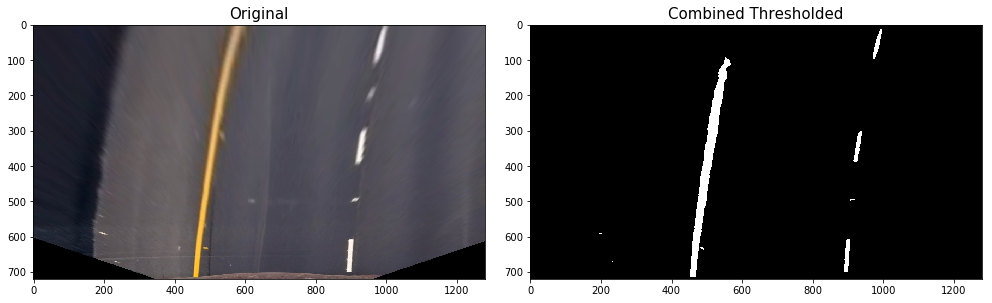

In [16]:
combined = np.zeros_like(bin_l)
combined[(bin_l==1) | (bin_b == 1)] = 1

fig, ax = plt.subplots(1, 2, figsize=(17,24))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
ax[0].set_title('Original', fontsize=15)
ax[1].set_title('Combined Thresholded', fontsize=15)

ax[0].imshow(test_img1_unwarped, cmap='gray')
ax[1].imshow(combined, cmap='gray')
plt.show()

### Absolute Sobel Threshold

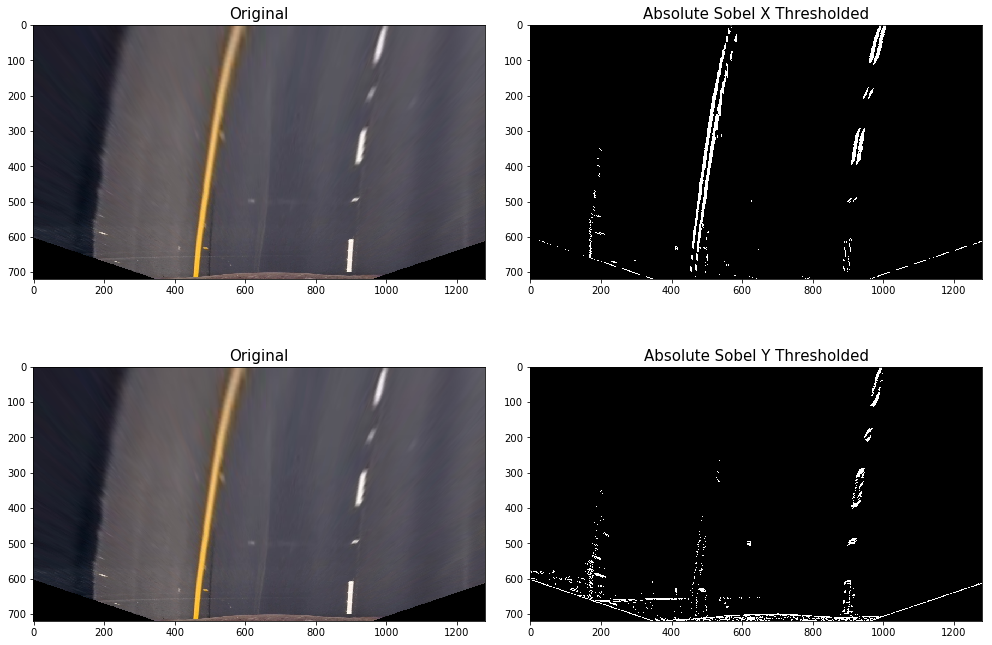

In [17]:
bin_x = abs_sobel_thresh(test_img1_unwarped, orient='x', thresh=(20, 100))
bin_y = abs_sobel_thresh(test_img1_unwarped, orient='y', thresh=(10, 255))

fig, ax = plt.subplots(2, 2, figsize=(17, 12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
ax = ax.ravel()

ax[0].set_title('Original', fontsize=15)
ax[1].set_title('Absolute Sobel X Thresholded', fontsize=15)
ax[2].set_title('Original', fontsize=15)
ax[3].set_title('Absolute Sobel Y Thresholded', fontsize=15)

ax[0].imshow(test_img1_unwarped, cmap='gray')
ax[1].imshow(bin_x, cmap='gray')
ax[2].imshow(test_img1_unwarped, cmap='gray')
ax[3].imshow(bin_y, cmap='gray')
plt.show()

### Sobel Magnitude Threshold

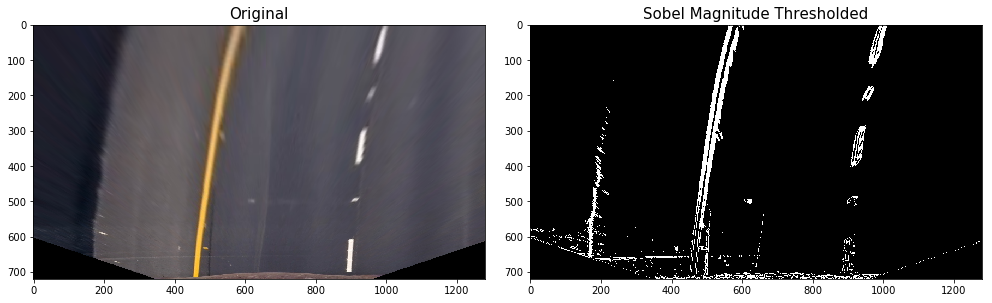

In [18]:
bin_mag = mag_thresh(test_img1_unwarped, thresh=(10, 50))

fig, ax = plt.subplots(1, 2, figsize=(17,24))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
ax[0].set_title('Original', fontsize=15)
ax[1].set_title('Sobel Magnitude Thresholded', fontsize=15)

ax[0].imshow(test_img1_unwarped, cmap='gray')
ax[1].imshow(bin_mag, cmap='gray')
plt.show()

### Sobel Direction Threshold

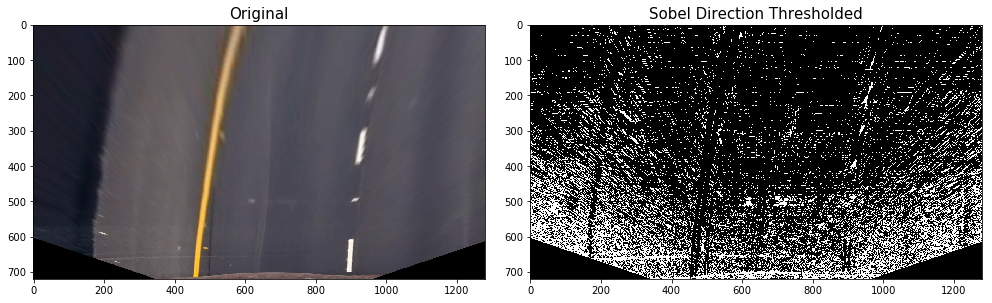

In [19]:
bin_dir = dir_threshold(test_img1_unwarped, thresh=(1, np.pi/2))

fig, ax = plt.subplots(1, 2, figsize=(17, 24))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
ax[0].set_title('Original', fontsize=15)
ax[1].set_title('Sobel Direction Thresholded', fontsize=15)

ax[0].imshow(test_img1_unwarped, cmap='gray')
ax[1].imshow(bin_dir, cmap='gray')
plt.show()

### Image processing pipeline

In [20]:
def image_process(img):
    # Undistorting image
    undist = correct_undistort(img, objpoints, imgpoints)
    
    # Perspective transform image
    unwarped, M, Minv = pers_transform(undist, src, dst)
    
    # Colour thresholding in L channel
    bin_l = hls_thresh(unwarped, channel_name='l', thresh=(200, 255))
    
    # Colour thresholding in B channel of LAB
    bin_b = lab_thresh(unwarped, channel_name='b', thresh=(190, 255))
    
    # Combining both thresholds
    combined = np.zeros_like(bin_l)
    combined[(bin_l==1) | (bin_b == 1)] = 1
    
    return combined, unwarped, Minv

### Test and display image processing pipeline

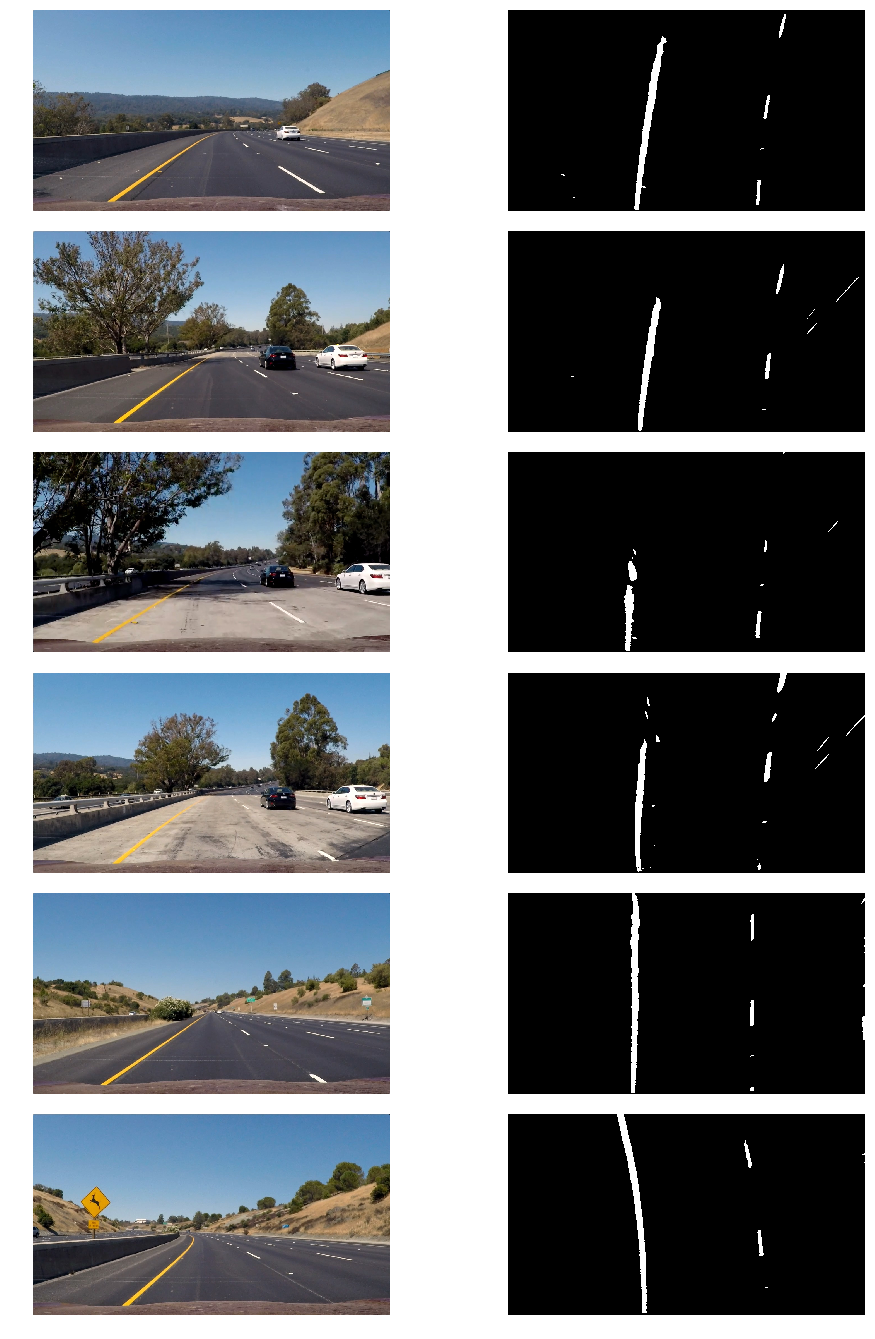

In [21]:
test_images_processed = []

fig, ax = plt.subplots(6, 2, figsize=(17, 24))
fig.subplots_adjust(hspace=0.1, wspace=0)

for i in range(6) :
    ax[i,0].imshow(test_images[i][0])
    thresh_img, unwarped, Minv = image_process(test_images[i][0])
    test_images_processed.append(thresh_img)
    ax[i,1].imshow(thresh_img,cmap='gray')
for axes in ax.flatten() :
    axes.axis('off')
plt.show()

### Implement Sliding Windows and Fit a Polynomial
Line Finding Method: Peaks in a Histogram

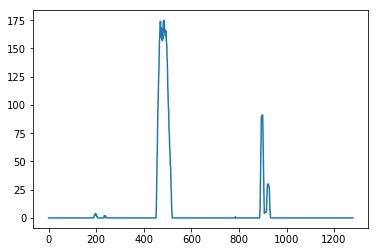

In [22]:
img = test_images_processed[0]
histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()

### Sliding Windows Search Function

In [46]:
def sliding_window_search(thresh_img):
    # Take a histogram of the bottom half of the image
    bottom_half_y = thresh_img.shape[0]/2
    histogram = np.sum(thresh_img[int(thresh_img.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((thresh_img, thresh_img, thresh_img)) * 255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(thresh_img.shape[0] / nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = thresh_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = thresh_img.shape[0] - (window+1)*window_height
        win_y_high = thresh_img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0, 0, 255), 4) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0, 0, 255), 4) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    left_fit = []
    right_fit = []
    
    # Fit a second order polynomial to each
    if len(leftx) != 0 and len(rightx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, thresh_img.shape[0]-1, thresh_img.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Generate black image and colour lane lines
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]

        # Draw polyline on image
        right = np.asarray(tuple(zip(right_fitx, ploty)), np.int32)
        left = np.asarray(tuple(zip(left_fitx, ploty)), np.int32)
        cv2.polylines(out_img, [right], False, (255 ,0 ,0), thickness=5)
        cv2.polylines(out_img, [left], False, (0, 255, 0), thickness=5)
        
    
    return left_lane_inds, right_lane_inds, left_fit, right_fit, out_img

### Test sliding window function

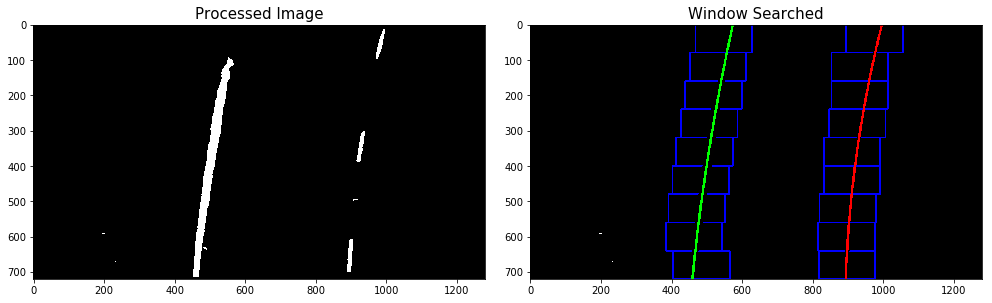

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(17, 24))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
ax[0].set_title('Processed Image', fontsize=15)
ax[1].set_title('Window Searched', fontsize=15)

thresholded_img, unwarped, Minv = image_process(test_images[0][0])
ax[0].imshow(thresholded_img, cmap='gray')
left, right, left_fit, right_fit, polynom_img = sliding_window_search(thresholded_img)
ax[1].imshow(polynom_img)

plt.savefig("output_images/sliding_windows_search.jpg")
plt.show()

### Margin Search Function

In [50]:
def margin_search(thresh_img, prev_left_fit, prev_right_fit):
    margin = 80
    
    nonzero = thresh_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + prev_left_fit[2] - margin)) & 
                      (nonzerox < (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + prev_left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + prev_right_fit[2] - margin)) & 
                       (nonzerox < (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + prev_right_fit[2] + margin)))
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Generate a blank image to draw on
    out_img = np.dstack((thresh_img, thresh_img, thresh_img))*255
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
        right_fit_new = np.polyfit(righty, rightx, 2)
        
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, thresh_img.shape[0]-1, thresh_img.shape[0] )
        left_fitx = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
        right_fitx = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]

        # Create an image to draw on and an image to show the selection window
        window_img = np.zeros_like(out_img)

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

         # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.intc([left_line_pts]), (0, 255, 0))
        cv2.fillPoly(window_img, np.intc([right_line_pts]), (0, 255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Draw polyline on image
        right = np.asarray(tuple(zip(right_fitx, ploty)), np.int32)
        left = np.asarray(tuple(zip(left_fitx, ploty)), np.int32)
        cv2.polylines(out_img, [right], False, (255, 255, 0), thickness=2)
        cv2.polylines(out_img, [left], False, (255, 255, 0), thickness=2)
    
    return left_lane_inds, right_lane_inds, out_img

### Test margin search function

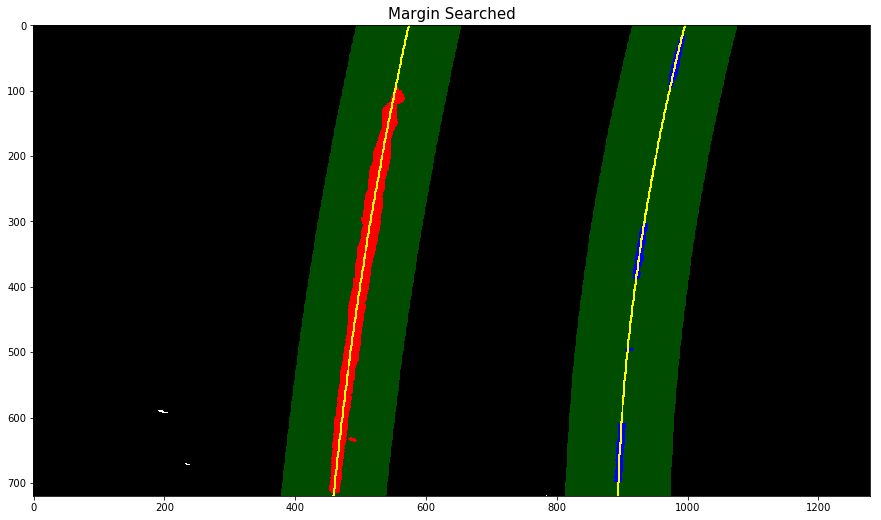

In [26]:
thresholded_img, unwarped, Minv = image_process(test_images[0][0])
# Apply margin search
left_lane_inds2, right_lane_inds2, visual_img = margin_search(thresholded_img, left_fit, right_fit)

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.set_title('Margin Searched', fontsize=15)
ax.imshow(visual_img)
plt.savefig("output_images/margin_search.jpg")
plt.show()

### Line Class
Line class for storing information about the lane lines and provide a method for updating the information

In [27]:
# Define a class to receive the characteristics of each line detection
from collections import deque

class Line():
    def __init__(self, maxSamples=4):
        
        self.maxSamples = maxSamples 
        # x values of the last n fits of the line
        self.recent_xfitted = deque(maxlen=self.maxSamples)
        # Polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # Polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # Average x values of the fitted line over the last n iterations
        self.bestx = None
        # Was the line detected in the last iteration?
        self.detected = False 
        # Radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # Distance in meters of vehicle center from the line
        self.line_base_pos = None 
         
    def update_lane(self, ally, allx):
        # Updates lanes on every new frame
        # Mean x value 
        self.bestx = np.mean(allx, axis=0)
        # Fit 2nd order polynomial
        new_fit = np.polyfit(ally, allx, 2)
        # Update current fit
        self.current_fit = new_fit
        # Add the new fit to the queue
        self.recent_xfitted.append(self.current_fit)
        # Use the queue mean as the best fit
        self.best_fit = np.mean(self.recent_xfitted, axis=0)
        # meters per pixel in y dimension
        ym_per_pix = 30/720
        # meters per pixel in x dimension
        xm_per_pix = 3.7/700
        # Calculate radius of curvature
        fit_cr = np.polyfit(ally*ym_per_pix, allx*xm_per_pix, 2)
        y_eval = np.max(ally)
        self.radius_of_curvature = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])

### Lane Validation
Checks if the detected lane is good enough to use as a reliable frame (number of points). If passed, updates the Line() class with the new lane polynomial.

In [28]:
def validate_lane_update(img, left_lane_inds, right_lane_inds):
    # Checks if detected lanes are good enough before updating
    img_size = (img.shape[1], img.shape[0])
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Extract left and right line pixel positions
    left_line_allx = nonzerox[left_lane_inds]
    left_line_ally = nonzeroy[left_lane_inds] 
    right_line_allx = nonzerox[right_lane_inds]
    right_line_ally = nonzeroy[right_lane_inds]
    
    # Discard lane detections that have very little points, 
    # as they tend to have unstable results in most cases
    if len(left_line_allx) <= 1800 or len(right_line_allx) <= 1800:
        left_line.detected = False
        right_line.detected = False
        return
    
    left_x_mean = np.mean(left_line_allx, axis=0)
    right_x_mean = np.mean(right_line_allx, axis=0)
    lane_width = np.subtract(right_x_mean, left_x_mean)
    
    # Discard the detections if lanes are not in their repective half of their screens
    if left_x_mean > 740 or right_x_mean < 740:
        left_line.detected = False
        right_line.detected = False
        return
    
    # Discard the detections if the lane width is too large or too small
    if  lane_width < 300 or lane_width > 800:
        left_line.detected = False
        right_line.detected = False
        return 
    
    # If this is the first detection or 
    # the detection is within the margin of the averaged n last lines 
    if left_line.bestx is None or np.abs(np.subtract(left_line.bestx, np.mean(left_line_allx, axis=0))) < 100:
        left_line.update_lane(left_line_ally, left_line_allx)
        left_line.detected = True
    else:
        left_line.detected = False
    if right_line.bestx is None or np.abs(np.subtract(right_line.bestx, np.mean(right_line_allx, axis=0))) < 100:
        right_line.update_lane(right_line_ally, right_line_allx)
        right_line.detected = True
    else:
        right_line.detected = False    
 
    # Calculate vehicle-lane offset
    xm_per_pix = 3.7/610 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    car_position = img_size[0]/2
    l_fit = left_line.current_fit
    r_fit = right_line.current_fit
    left_lane_base_pos = l_fit[0]*img_size[1]**2 + l_fit[1]*img_size[1] + l_fit[2]
    right_lane_base_pos = r_fit[0]*img_size[1]**2 + r_fit[1]*img_size[1] + r_fit[2]
    lane_center_position = (left_lane_base_pos + right_lane_base_pos) /2
    left_line.line_base_pos = (car_position - lane_center_position) * xm_per_pix + 0.2
    right_line.line_base_pos = left_line.line_base_pos

### Lane Drawing and Stats
Function find_lanes performs a margin search if a previous lane had been found. Otherwise, it performs a fresh window_search. write_stats simply renders stats about lane curvature and vehicle offset. draw_lane draws the lane overlay onto the warped image, and warps it back into its original perspective (dashcam)

In [29]:
def find_lanes(img):
    if left_line.detected and right_line.detected:  # Perform margin search if exists prior success.
        # Margin Search
        left_lane_inds, right_lane_inds, out_img = margin_search(img, left_line.current_fit, right_line.current_fit)        
    else:  # Perform a full window search if no prior successful detections.
        # Window Search
        left_lane_inds, right_lane_inds, temp_left_fit, temp_right_fit, out_img = sliding_window_search(img)
    # Update the lane detections
    validate_lane_update(img, left_lane_inds, right_lane_inds)
    return out_img


def write_stats(img):
    font = cv2.FONT_HERSHEY_PLAIN
    size = 3
    weight = 2
    color = (255,255,255)
    
    radius_of_curvature = (left_line.radius_of_curvature + right_line.radius_of_curvature)/2
    cv2.putText(img,'Lane Curvature Radius: '+ '{0:.2f}'.format(radius_of_curvature)+'m',(30,60), font, size, color, weight)

    if (left_line.line_base_pos >=0):
        cv2.putText(img,'Vehicle is '+ '{0:.2f}'.format(left_line.line_base_pos*100)+'cm'+ ' Right of Center',(30,100), font, size, color, weight)
    else:
        cv2.putText(img,'Vehicle is '+ '{0:.2f}'.format(abs(left_line.line_base_pos)*100)+'cm' + ' Left of Center',(30,100), font, size, color, weight)
        
        
def draw_lane(undist, img, Minv):
    # Generate x and y values for plotting
    ploty = np.linspace(0, undist.shape[0] - 1, undist.shape[0])
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img).astype(np.uint8)
    color_warp = np.stack((warp_zero, warp_zero, warp_zero), axis=-1)

    left_fit = left_line.best_fit
    right_fit = right_line.best_fit
    
    if left_fit is not None and right_fit is not None:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (64, 224, 208))
        
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
        
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.6, 0)
        write_stats(result)
        return result
    return undist

In [30]:
def assemble_img(warped, threshold_img, polynomial_img, lane_img):
    # Define output image
    # Main image
    img_out=np.zeros((720, 1707, 3), dtype=np.uint8)
    img_out[0:720, 0:1280, :] = lane_img
    
    # Text formatting
    fontScale=1
    thickness=1
    fontFace = cv2.FONT_HERSHEY_PLAIN
    
    # Perspective transform image
    img_out[0:240, 1281:1707, :] = cv2.resize(warped, (426, 240))
    boxsize, _ = cv2.getTextSize("Transformed", fontFace, fontScale, thickness)
    cv2.putText(img_out, "Transformed", (int(1494-boxsize[0]/2), 40), fontFace, fontScale,(255, 255, 255), thickness,  lineType = cv2.LINE_AA)
   
    # Threshold image
    resized = cv2.resize(threshold_img, (426, 240))
    resized=np.uint8(resized)
    gray_image = cv2.cvtColor(resized*255, cv2.COLOR_GRAY2RGB)
    img_out[241:481, 1281:1707, :] = cv2.resize(gray_image,(426, 240))
    boxsize, _ = cv2.getTextSize("Filtered", fontFace, fontScale, thickness)
    cv2.putText(img_out, "Filtered", (int(1494-boxsize[0]/2), 281), fontFace, fontScale,(255, 255, 255), thickness, lineType = cv2.LINE_AA)
 
    # Polynomial lines
    img_out[480:720, 1281:1707, :] = cv2.resize(polynomial_img,(426, 240))
    boxsize, _ = cv2.getTextSize("Detected Lanes", fontFace, fontScale, thickness)
    cv2.putText(img_out, "Detected Lanes", (int(1494-boxsize[0]/2), 521), fontFace, fontScale,(255, 255, 255), thickness,  lineType = cv2.LINE_AA)
    
    return img_out

### Final Pipeline

In [84]:
def do_process_img(img):
    # Undistorting image
    undist = correct_undistort(img, objpoints, imgpoints)
    
    # Perspective transform image
    unwarped, M, Minv = pers_transform(undist, src, dst)
    
    # Colour thresholding in L channel
    bin_l = hls_thresh(unwarped, channel_name='l', thresh=(200, 255))
    
    # Colour thresholding in B channel of LAB
    bin_b = lab_thresh(unwarped, channel_name='b', thresh=(190, 255))
    
    # Combining both thresholds
    combined = np.zeros_like(bin_l)
    combined[(bin_l==1) | (bin_b == 1)] = 1
    
    # Draw lanes on image
    output_img = find_lanes(combined)
    
    # Draw lanes on image
    lane_img = draw_lane(undist, combined, Minv);  
    
    result = assemble_img(unwarped, combined, output_img, lane_img)
    
    return result

### Single frame iteration

Done


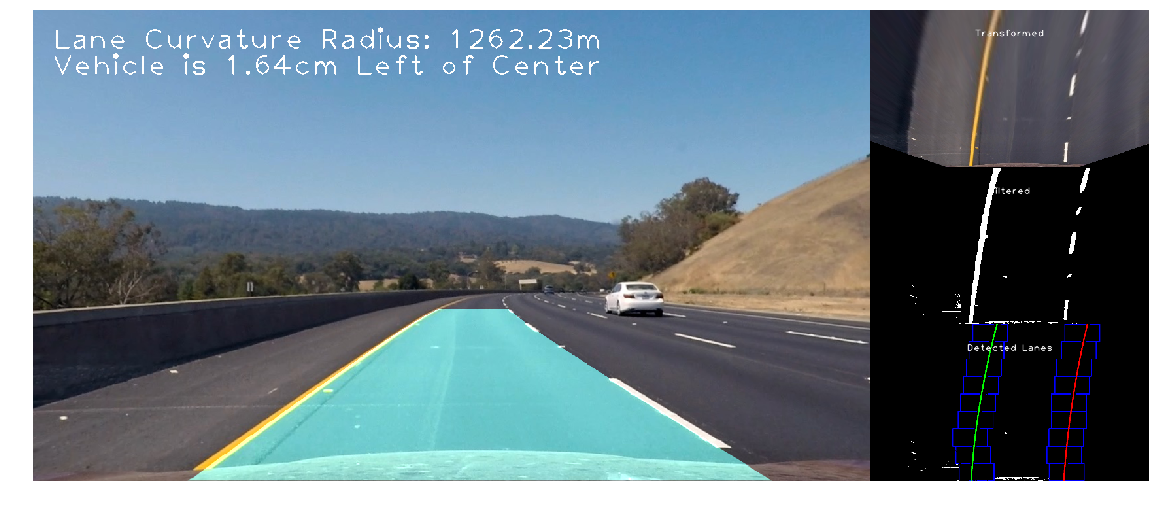

In [81]:
left_line = Line()
right_line = Line()

plt.figure(figsize = (20,20))
plt.imshow(do_process_img(test_images[0][0]))
plt.axis('off')
print ("Done")
plt.savefig("output_images/assembled_img.jpg")

### Video Import Packages

In [61]:
# Needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Importing videos for processing
project_clip = VideoFileClip("project_video.mp4")
challenge_clip = VideoFileClip("challenge_video.mp4").subclip(0, 5)
harder_challenge_clip = VideoFileClip("harder_challenge_video.mp4").subclip(0, 5)

### Process Project Video

In [34]:
# Initialize Left and Right Lanes
left_line = Line()
right_line = Line()
# Reset and Calibrate
project_output = 'project_clip_result.mp4'
project_video_clip = project_clip.fl_image(do_process_img)
project_video_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_clip_result.mp4
[MoviePy] Writing video project_clip_result.mp4


100%|█████████▉| 1260/1261 [15:29<00:00,  1.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_clip_result.mp4 



In [35]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))